In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("US_Accidents_50k.csv")
print(df.shape)
df.head()

(50000, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3135565,Source2,3,2017-12-18 20:39:26,2017-12-18 21:24:05,26.231586,-80.136581,NaN,NaN,0.000,Right lane blocked due to accident on I-95 Nor...,W Atlantic Blvd,Pompano Beach,Broward,FL,33069,US,US/Eastern,KFXE,2017-12-18 20:53:00,71.1,NaN,93.0,30.26,10.0,ESE,4.6,NaN,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-3933005,Source1,2,2022-01-12 08:33:00,2022-01-12 10:46:35,28.541458,-81.475852,28.539172,-81.475874,0.158,Slow traffic on County Hwy-435 from Grand Junc...,N Hiawassee Rd,Orlando,Orange,FL,32835,US,US/Eastern,KORL,2022-01-12 08:53:00,64.0,64.0,70.0,30.15,10.0,NE,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-1263310,Source2,2,2020-11-17 10:36:29,2020-11-17 11:06:05,29.851583,-95.504662,NaN,NaN,0.000,Accident on Tidwell Rd at Hollister St.,W Tidwell Rd,Houston,Harris,TX,77040,US,US/Central,KDWH,2020-11-17 10:53:00,69.0,69.0,31.0,30.30,10.0,ENE,9.0,0.0,Fair,False,False,True,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
3,A-7511056,Source1,2,2018-11-29 17:28:45,2018-11-29 21:28:44,42.148838,-121.698240,42.143724,-121.698269,0.353,At Dehlinger Ln/Lower Klamath Hwy - Accident.,Highway 39,Klamath Falls,Klamath,OR,97603-9712,US,US/Pacific,KLMT,2018-11-29 17:53:00,37.9,NaN,93.0,29.56,10.0,Calm,NaN,0.0,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
4,A-7743457,Source1,2,2019-06-26 06:35:00,2019-06-26 07:45:00,40.914630,-111.891470,40.908653,-111.891500,0.413,At US-89/500/Exit 317 - Accident.,I-15 S,Centerville,Davis,UT,84014,US,US/Mountain,KSLC,2019-06-26 06:54:00,69.0,69.0,30.0,25.61,10.0,ESE,8.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


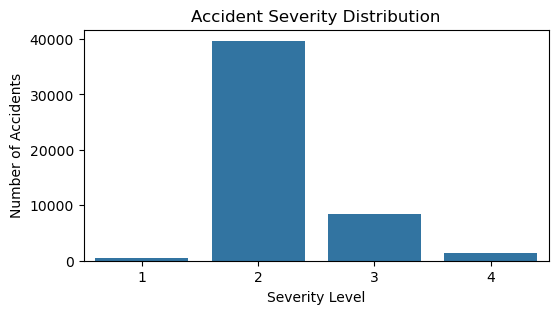

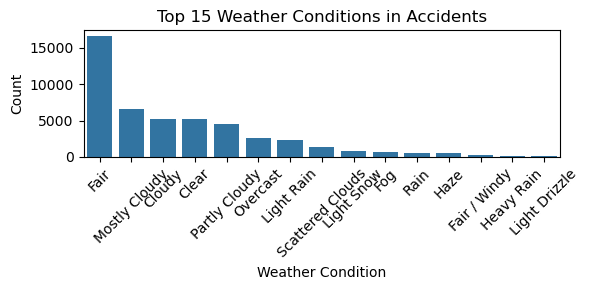

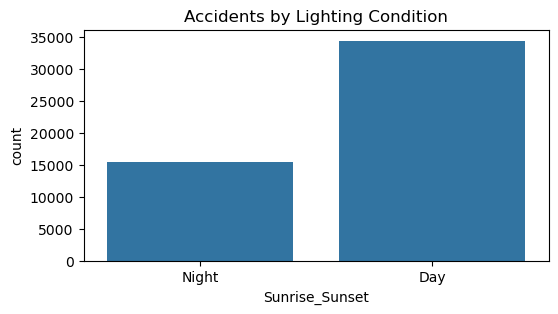

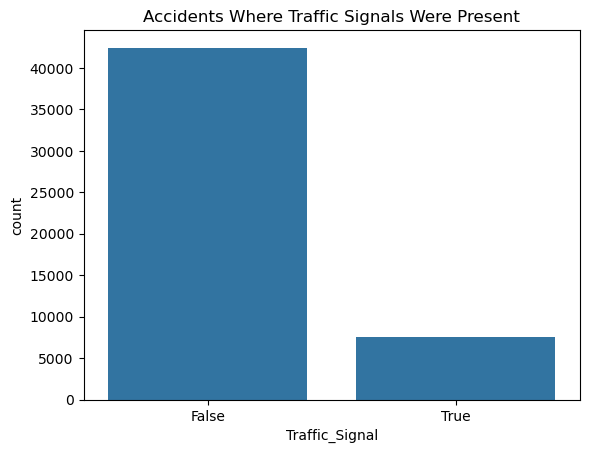

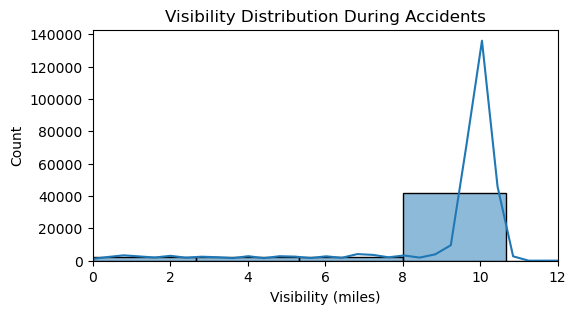

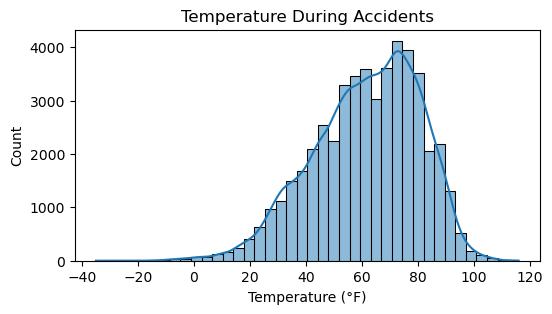

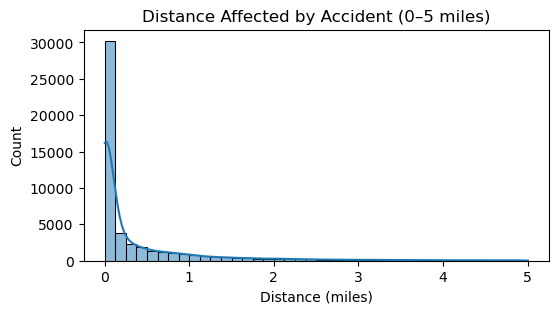

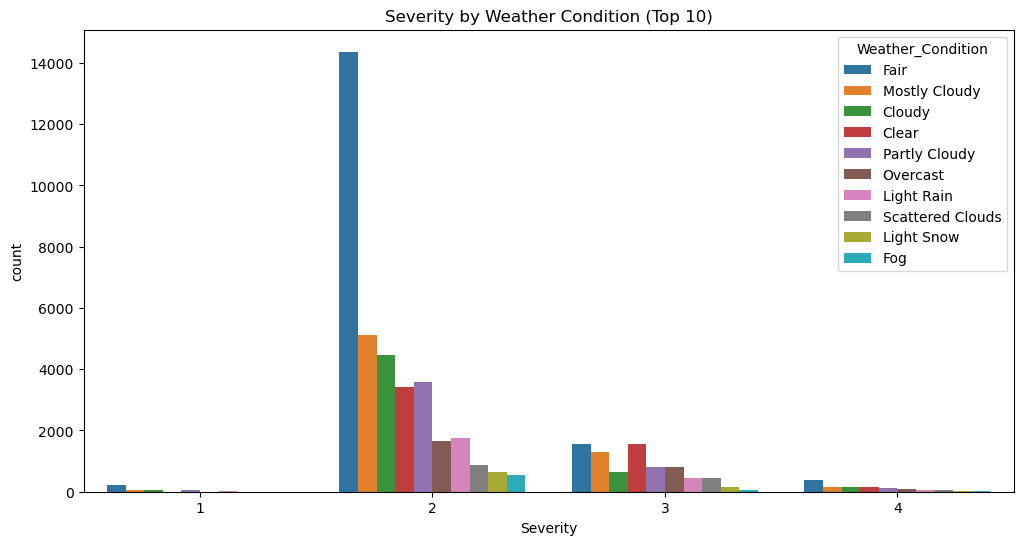

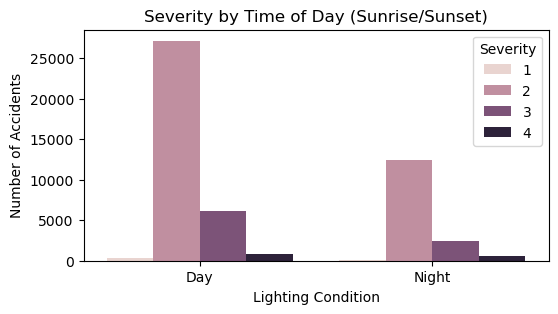

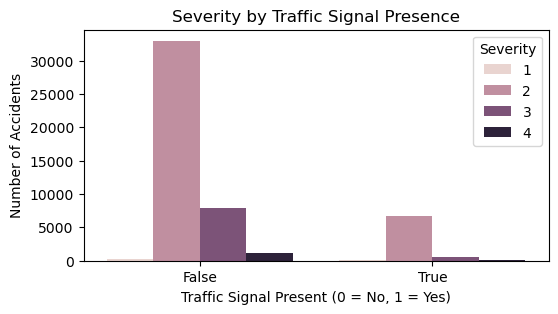

In [28]:
#Visualize the data -- Univariate
plt.figure(figsize=(6,3))
sns.countplot(x='Severity', data=df)
plt.title("Accident Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Number of Accidents")
plt.show()

plt.figure(figsize=(6,3))
top_weather = df['Weather_Condition'].value_counts().nlargest(15)
sns.barplot(x=top_weather.index, y=top_weather.values)
plt.title("Top 15 Weather Conditions in Accidents")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(x='Sunrise_Sunset', data=df)
plt.title("Accidents by Lighting Condition")
plt.show()

sns.countplot(x='Traffic_Signal', data=df)
plt.title("Accidents Where Traffic Signals Were Present")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df['Visibility(mi)'], bins=30, kde=True)
plt.title("Visibility Distribution During Accidents")
plt.xlim(0,12)
plt.xlabel("Visibility (miles)")
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df['Temperature(F)'], bins=40, kde=True)
plt.title("Temperature During Accidents")
plt.xlabel("Temperature (°F)")
plt.show()

plt.figure(figsize=(6, 3))
filtered_df = df[df['Distance(mi)'] <= 5]
sns.histplot(filtered_df['Distance(mi)'], bins=40, kde=True)
plt.title("Distance Affected by Accident (0–5 miles)")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
plt.show()


#Visualize the data -- Multivariate
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Severity', hue='Weather_Condition',
              order=[1,2,3,4], hue_order=df['Weather_Condition'].value_counts().index[:10])
plt.title("Severity by Weather Condition (Top 10)")
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Sunrise_Sunset', hue='Severity', order=['Day', 'Night'], hue_order=[1,2,3,4])
plt.title("Severity by Time of Day (Sunrise/Sunset)")
plt.xlabel("Lighting Condition")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Traffic_Signal', hue='Severity', hue_order=[1,2,3,4])
plt.title("Severity by Traffic Signal Presence")
plt.xlabel("Traffic Signal Present (0 = No, 1 = Yes)")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.show()


In [29]:
#Preprocessing

df_clean = df.copy()
print("Initial shape:", df_clean.shape)

# converting start/end time to datetime format
df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'], errors='coerce')
df_clean['End_Time'] = pd.to_datetime(df_clean['End_Time'], errors='coerce')
print("\nConverted Start_Time and End_Time to datetime.")

# drop invalid/missing
df_clean = df_clean.dropna(subset=['Start_Time', 'End_Time'])
print("\nShape after dropping invalid datetimes:", df_clean.shape)

# time based features based on converted datetime
df_clean['Hour'] = df_clean['Start_Time'].dt.hour
df_clean['DayOfWeek'] = df_clean['Start_Time'].dt.dayofweek  # Monday=0, Sunday=6
df_clean['Month'] = df_clean['Start_Time'].dt.month
df_clean['Is_Weekend'] = df_clean['DayOfWeek'].isin([5,6])
df_clean['Duration(mins)'] = (df_clean['End_Time'] - df_clean['Start_Time']).dt.total_seconds() / 60

print("\nCreated time-based features: Hour, DayOfWeek, Month, Is_Weekend, Duration(mins).")

# missing num vals
num_cols = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
            'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
for col in num_cols:
    missing_before = df_clean[col].isna().sum()
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    missing_after = df_clean[col].isna().sum()
    print(f"Filled missing values in '{col}' | Before: {missing_before}, After: {missing_after}")

# encoding lighting
df_clean['Is_Night'] = df_clean['Sunrise_Sunset'].apply(lambda x: 1 if x == 'Night' else 0)
print("\nEncoded 'Sunrise_Sunset' into binary 'Is_Night'.")

# dropping extreme outliers
df_clean = df_clean[df_clean['Severity'].notnull()]
df_clean = df_clean[df_clean['Duration(mins)'] < 1000]  # remove super long events
print("\nFinal cleaned shape:", df_clean.shape)

# encoding weather condition to simplify
def map_weather_condition(condition):
    condition = str(condition).lower()
    if "fair" in condition or "clear" in condition:
        return "Clear"
    elif "cloud" in condition or "overcast" in condition or "scattered" in condition:
        return "Cloudy"
    elif "rain" in condition or "drizzle" in condition or "shower" in condition:
        return "Rain"
    elif "snow" in condition or "wintry" in condition or "ice" in condition:
        return "Snow"
    elif "fog" in condition or "haze" in condition or "smoke" in condition:
        return "Fog"
    elif "thunder" in condition or "t-storm" in condition:
        return "Thunderstorm"
    else:
        return "Other"

# applying the mapping
df_clean['Weather_Simplified'] = df_clean['Weather_Condition'].apply(map_weather_condition)
print("\nMapped Weather_Condition into simplified categories.")

# encode simplified categories
weather_dummies = pd.get_dummies(df_clean['Weather_Simplified'], prefix='Weather')
df_clean = pd.concat([df_clean, weather_dummies], axis=1)
print("\nOne-hot encoded simplified weather categories:", list(weather_dummies.columns))

# sample
print("\n", df_clean[['Weather_Condition', 'Weather_Simplified'] + list(weather_dummies.columns)].head())

df_clean['Low_Visibility_Flag'] = df_clean['Visibility(mi)'] < 3
print(f"Added 'Low_Visibility_Flag'. Total low visibility records: {df_clean['Low_Visibility_Flag'].sum()}")

# looking at new features
print("\n", df_clean[['Start_Time', 'Hour', 'DayOfWeek', 'Is_Weekend', 'Duration(mins)', 'Is_Night']].head())

print("\n\nFinal Dataset Setup") 
print("Shape of dataset:", df_clean.shape)
print("Columns:\n", df_clean.columns.tolist())
# Temporarily set display options
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # prevent line wrapping
pd.set_option('display.max_rows', 100)      # limit to 100 rows (adjust as needed)

print(df_clean.head(10))  # show first 10 rows
df_clean.to_csv("cleaned_accidents.csv", index=False)


Initial shape: (50000, 46)

Converted Start_Time and End_Time to datetime.

Shape after dropping invalid datetimes: (45222, 46)

Created time-based features: Hour, DayOfWeek, Month, Is_Weekend, Duration(mins).
Filled missing values in 'Temperature(F)' | Before: 910, After: 0
Filled missing values in 'Wind_Chill(F)' | Before: 12939, After: 0
Filled missing values in 'Humidity(%)' | Before: 972, After: 0
Filled missing values in 'Pressure(in)' | Before: 778, After: 0
Filled missing values in 'Visibility(mi)' | Before: 999, After: 0
Filled missing values in 'Wind_Speed(mph)' | Before: 3528, After: 0
Filled missing values in 'Precipitation(in)' | Before: 14198, After: 0

Encoded 'Sunrise_Sunset' into binary 'Is_Night'.

Final cleaned shape: (44969, 52)

Mapped Weather_Condition into simplified categories.

One-hot encoded simplified weather categories: ['Weather_Clear', 'Weather_Cloudy', 'Weather_Fog', 'Weather_Other', 'Weather_Rain', 'Weather_Snow', 'Weather_Thunderstorm']

   Weather_Con